In [6]:
# Google Colabでkaggle.jsonをアップロード
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kojikojipro","key":"04c6e3329de941099c00e7a9a89a384a"}'}

In [0]:
# Google Colabでkaggle.jsonをフォルダ移動
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Google Colabでデータセットをダウンロード
!pip install kaggle
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 5.80MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 59.6MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.6MB/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# テストデータの'PassengerId'を取得しておく
passenger_id = test.loc[:, 'PassengerId']

# 表示
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Nullデータの確認
print(pd.isnull(train).sum())
print(pd.isnull(test).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


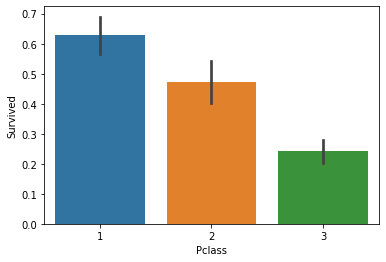

In [4]:
# Pclassの生存率
sns.barplot(x='Pclass', y='Survived', data=train)

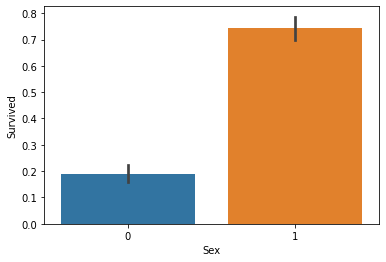

In [5]:
# 性別毎の生存率
# 性別を数値に置き換える
func = lambda x: 0 if x == 'male' else 1
train['Sex'] = train['Sex'].map(func)
test['Sex'] = test['Sex'].map(func)

# 生存率を表示
sns.barplot(x='Sex', y='Survived', data=train)

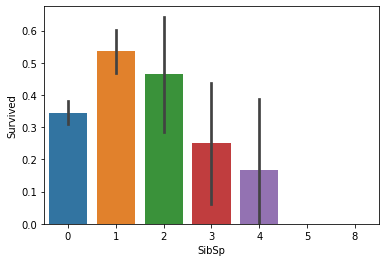

In [6]:
# SibSpの生存率
sns.barplot(x='SibSp', y='Survived', data=train)

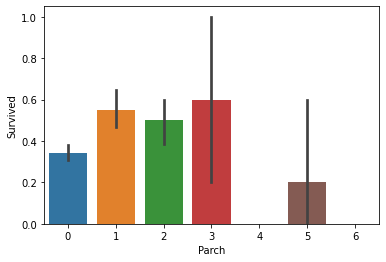

In [7]:
# Parchの生存率
sns.barplot(x="Parch", y="Survived", data=train)

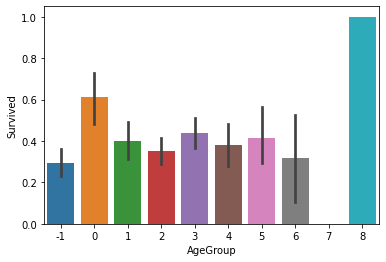

In [8]:
# 年齢ごとの生存率
# Nullのデータに-1を代入する
train['Age'] = train['Age'].fillna(-1)
test['Age'] = test['Age'].fillna(-1)

# 10歳毎に分割する
func = lambda x: int(x / 10) if x >= 0 else -1
train['AgeGroup'] = train['Age'].map(func)
test['AgeGroup'] = test['Age'].map(func)

# 生存率を表示
sns.barplot(x='AgeGroup', y='Survived', data=train)

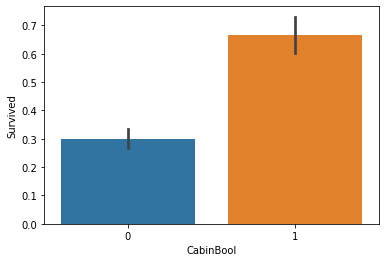

In [9]:
# Cabinの生存率
# CabinのデータはNanを0、それ以外を1に置き換える
func = lambda x: 0 if pd.isnull(x) else 1
train['CabinBool'] = train['Cabin'].map(func)
test['CabinBool'] = test['Cabin'].map(func)

# 生存率を表示
sns.barplot(x='CabinBool', y='Survived', data=train)

512.3292
0.0


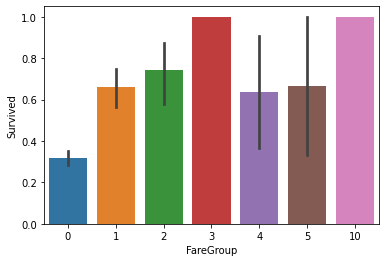

In [10]:
# Fareの生存率
# テストデータにNullがあるので0を入れる
test['Fare'] = test['Fare'].fillna(-1)
# 最大値と最小値を確認
print(max(train['Fare']))
print(min(train['Fare']))

# 10段階で分割する
fare = (max(train['Fare']) - min(train['Fare'])) / 10
func = lambda x: int(x / fare)
train['FareGroup'] = train['Fare'].map(func)
test['FareGroup'] = test['Fare'].map(func)

# 生存率を表示
sns.barplot(x='FareGroup', y='Survived', data=train)
plt.show()

S:644
C:168
Q:77


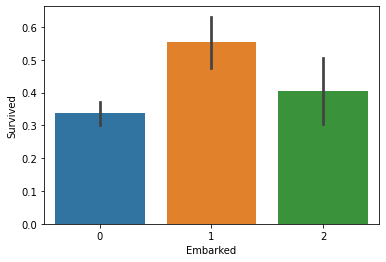

In [17]:
# Embarkedごとの生存率
# nullのデータは一番頻度の高いものに置き換える
embarked_list = ['S', 'C', 'Q']
max_count = 0
max_index = 0
for i, embarked in enumerate(embarked_list):
    now_count = (train['Embarked'] == embarked).sum()
    print('{}:{}'.format(embarked, now_count))
    if max_count < now_count:
        max_index = i

train['Embarked'] = train['Embarked'].fillna(embarked_list[max_index])

# 数字に置き換える
_, uniques = pd.factorize(train['Embarked'])
convertor = {key: value for value, key in enumerate(uniques)}
func = lambda x: convertor[x]
train['Embarked'] = train['Embarked'].map(func)
test['Embarked'] = test['Embarked'].map(func)

# 生存率を表示
sns.barplot(x='Embarked', y='Survived', data=train)

In [24]:
# 年齢のNullをSVMで予測する
svm_train = train[train['Age'] != -1]
svm_test = train[train['Age'] == -1]

# 必要なカラムを取り出す
x_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'FareGroup', 'CabinBool', 'Embarked']
pca_data = train.loc[:, x_cols]
svm_train_x = svm_train.loc[:, x_cols]
svm_train_y = svm_train.loc[:, 'AgeGroup']
svm_test_x = svm_test.loc[:, x_cols]

# PCA
pca = PCA(n_components=6)
pca.fit(pca_data)
svm_train_x = pca.transform(svm_train_x)
svm_test_x = pca.transform(svm_test_x)

# SVM
svm = SVC(kernel='rbf', random_state=None)
svm.fit(svm_train_x, svm_train_y)

pred_train = svm.predict(svm_train_x)
accuracy_train = accuracy_score(svm_train_y, pred_train)
print('トレーニングデータに対する正解率： %.2f' % accuracy_train)

# モデルを使って予測する
pred = svm.predict(svm_test_x)
print(pred)
print(len(pred))
print(len(train[train['Age'] == -1]))
train[train['Age'] == -1, 'AgeGroup'] = svm.predict(svm_test_x)
train[train['Age'] == -1]

トレーニングデータに対する正解率： 0.43
[2 2 1 2 1 2 3 1 2 2 2 2 1 2 3 3 0 2 2 1 2 2 2 2 1 2 2 0 0 2 2 3 3 3 0 3 2
 3 1 2 1 3 2 2 0 2 1 1 2 3 2 1 3 1 2 3 3 3 1 2 3 2 3 3 1 3 2 2 3 2 1 1 2 1
 1 3 2 2 0 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 2 0 2 2 2 1 3 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 3 2 1 2 2 3 2 2 2 2 1 2 2 3 2 1 2 1 0 3 2
 1 2 2 2 3 2 3 2 2 2 2 0 2 3 3 3 2 2 2 2 2 3 3 3 2 3 2 2 0]
177
177


ValueError: ignored

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def to_cuda(obj):
    if torch.cuda.is_available():
        return obj.cuda()
    return obj

In [0]:
input_size = len(train_x.columns)
outpu_size = len(train_y.columns)

train_x = torch.FloatTensor(np.array(train_x))
train_x = to_cuda(train_x)
train_y = torch.FloatTensor(np.array(train_y))
train_y = to_cuda(train_y)

In [0]:
HIDDEN_SIZE = 32
EPOCH_NUM = 300
BATCH_SIZE = 10

train = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

net = Net(input_size, HIDDEN_SIZE, outpu_size)
net = to_cuda(net)
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


Epoch: 50 | Avearage Loss: 1
Epoch: 100 | Avearage Loss: 1
Epoch: 150 | Avearage Loss: 1
Epoch: 200 | Avearage Loss: 1
Epoch: 250 | Avearage Loss: 1
Epoch: 300 | Avearage Loss: 0


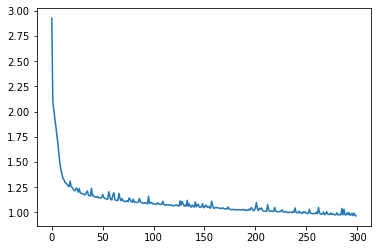

In [0]:
# 学習
loss_log = []
for e in range(EPOCH_NUM):
    total_loss = 0
    for x, y in train_loader:
        x, y = Variable(x), Variable(y)
        optimizer.zero_grad()
        output = net(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    ave_loss = total_loss / BATCH_SIZE
    loss_log.append(ave_loss)

    if (e + 1) % 50 == 0:
        print('Epoch: %d | Avearage Loss: %d' % (e + 1, ave_loss))

plt.plot([i for i in range(len(loss_log))], loss_log)

In [0]:
test = torch.FloatTensor(np.array(test))
test = to_cuda(test)
test = Variable(test)

net.eval()
result = torch.max(net(test).data, 1)[1]

In [0]:
# Google ColabでSubmit用ファイル保存
submission = pd.DataFrame()
submission['PassengerId'] = passenger_id
submission['Survived'] = result.data.numpy()
submission.to_csv('titanic_submission.csv', index=False)